In [197]:
# 라이브러리 import 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest

# for Cramer' V
from scipy.stats.contingency import association
from sklearn import preprocessing
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='AppleGothic')

### 1. 데이터 불러오기

In [198]:
df = pd.read_csv('accepted.csv')
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
selected_cols = [
    'loan_status',      # 타겟: 상환 여부
    'annual_inc',        # 연간 소득
    'dti',               # 총부채상환비율 (빚/소득)
    'home_ownership',    # 주거 형태 (자가, 월세 등)
    'fico_range_low',    # 신용점수 하한선
    'revol_util',        # 리볼빙 이용률
    'delinq_2yrs',       # 지난 2년간 30일 이상 연체한 횟수
    'pub_rec',           # 파산 등 공적 기록 횟수
    'loan_amnt',         # 대출 원금
    'int_rate',          # 이자율
    'term',              # 대출 기간
    'purpose',           # 대출 목적
    'grade'             # 신용 등급
]

df_analysis = df[selected_cols]

In [200]:
df_analysis.head()

,loan_status,annual_inc,dti,home_ownership,fico_range_low,revol_util,delinq_2yrs,pub_rec,loan_amnt,int_rate,term,purpose,grade
0,Fully Paid,55000.0,5.91,MORTGAGE,675.0,29.7,0.0,0.0,3600.0,13.99,36 months,debt_consolidation,C
1,Fully Paid,65000.0,16.06,MORTGAGE,715.0,19.2,1.0,0.0,24700.0,11.99,36 months,small_business,C
2,Fully Paid,63000.0,10.78,MORTGAGE,695.0,56.2,0.0,0.0,20000.0,10.78,60 months,home_improvement,B
3,Current,110000.0,17.06,MORTGAGE,785.0,11.6,0.0,0.0,35000.0,14.85,60 months,debt_consolidation,C
4,Fully Paid,104433.0,25.37,MORTGAGE,695.0,64.5,1.0,0.0,10400.0,22.45,60 months,major_purchase,F


### 2. 결측치 탐색 및 제거

In [201]:
# 결측치 확인
df_analysis.isnull().sum()

loan_status         33
annual_inc          37
dti               1744
home_ownership      33
fico_range_low      33
revol_util        1835
delinq_2yrs         62
pub_rec             62
loan_amnt           33
int_rate            33
term                33
purpose             33
grade               33
dtype: int64

- 결측치 제거 목록

1. 모든 컬럼이 Null인 경우 **(제거)**
거의 모든 필수 컬럼에 공통적으로 33개의 결측치가 있는데 이는 시스템 오류로 인해 빈값으로 데이터에 업로드가 된것으로 판단되어 제거

2. delinq_2yrs, pub_rec **(제거)**
대략 60여개의 결측치가 있음
신용 조회나 연체기록이 NaN인 경우 시스템상 해당 사항이 없다(0건) 일 확률이 높다라고 확인하였지만 개인정보를 임의로 수정하거나 대체하는것은 옳지 않다고 판단 + 소수라 제거

3. dti, revol_util **(제거)**
각각 1744, 1835개의 결측치가 있음 (annual은 33개)
해당 컬럼들은 리스크 판단의 핵심 근거로 다른 값으로 채우기엔 위험하며 (개인정보 + 부채비율관련) 비율 역시도 굉장히 적기때문에 제거

In [202]:
# 1) 모든 컬럼이 null인 행만 제거
df_analysis = df_analysis.dropna(how='all')

In [203]:
df_analysis.isnull().sum()

loan_status          0
annual_inc           4
dti               1711
home_ownership       0
fico_range_low       0
revol_util        1802
delinq_2yrs         29
pub_rec             29
loan_amnt            0
int_rate             0
term                 0
purpose              0
grade                0
dtype: int64

In [ ]:
# 2) delinq_2yrs, pub_rec 제거
drop_cols = ['delinq_2yrs', 'pub_rec']
df_analysis.fillna(subset=drop_cols, inplace=True)

df_analysis.isnull().sum()
# annual_inc 4건도 같이 제거됨

loan_status          0
annual_inc           0
dti               1711
home_ownership       0
fico_range_low       0
revol_util        1773
delinq_2yrs          0
pub_rec              0
loan_amnt            0
int_rate             0
term                 0
purpose              0
grade                0
dtype: int64

In [205]:
# 3) dti, revol_util 제거 
drop_cols = ['dti', 'revol_util']
df_analysis.dropna(subset=drop_cols, inplace=True)

# 확인
print('--- 전처리 확인 ---')
df_analysis.isnull().sum()

--- 전처리 확인 ---


loan_status       0
annual_inc        0
dti               0
home_ownership    0
fico_range_low    0
revol_util        0
delinq_2yrs       0
pub_rec           0
loan_amnt         0
int_rate          0
term              0
purpose           0
grade             0
dtype: int64

### 3. 이상치 처리

##### 1. annual_inc
##### 2. revol_util
##### 3. dti
##### 4. pub_rec

#### 3.1 annual_inc

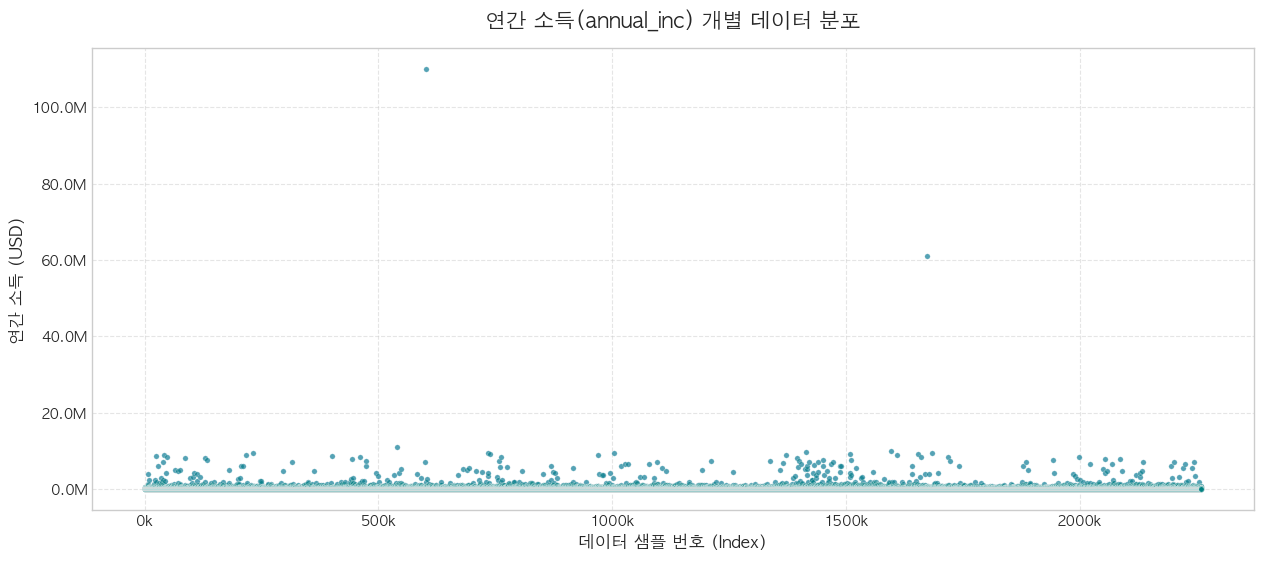

In [206]:
# 1) 연봉 이상치 제거 : 기준 천만 이상 제거 

import matplotlib.ticker as ticker

plt.figure(figsize=(15, 6))

sns.scatterplot(x=df_analysis.index, y=df_analysis['annual_inc'], alpha=0.5, s=15)
sns.scatterplot(x=df_analysis.index, y=df_analysis['annual_inc'], alpha=0.4, s=15, color='teal')

def million_formatter(x, pos):
    return f'{x / 1_000_000:.1f}M'
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(million_formatter))

def kilo_formatter(x, pos):
    return f'{int(x / 1_000)}k'
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(kilo_formatter))

plt.title('연간 소득(annual_inc) 개별 데이터 분포', fontsize=15, pad=15)
plt.ylabel('연간 소득 (USD)', fontsize=12)
plt.xlabel('데이터 샘플 번호 (Index)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [207]:
df_high_inc = df_analysis[df_analysis['annual_inc'] >= 10000000]

print(f"이상치 제거 전 데이터 개수: {len(df_analysis):,}건")
print(f"현재 연소득 최대값: ${df_analysis['annual_inc'].max():,.0f}")

이상치 제거 전 데이터 개수: 2,257,159건
현재 연소득 최대값: $110,000,000


In [208]:
df_high_inc

,loan_status,annual_inc,dti,home_ownership,fico_range_low,revol_util,delinq_2yrs,pub_rec,loan_amnt,int_rate,term,purpose,grade
539807,Fully Paid,10999200.0,0.07,RENT,685.0,41.1,1.0,0.0,5000.0,18.06,36 months,major_purchase,D
601128,Current,110000000.0,0.01,RENT,695.0,83.5,0.0,0.0,30000.0,9.93,60 months,debt_consolidation,B
1673140,Current,61000000.0,0.01,MORTGAGE,690.0,35.1,0.0,0.0,10000.0,11.44,36 months,debt_consolidation,B


In [209]:
# 천만 이상 연봉 이상치 제거
df_cleaned = df_analysis.drop(df_high_inc.index)

In [210]:
print(f'이상치 제거 개수: {len(df_analysis) - len(df_cleaned)} 건')

print(f"이상치 제거 후 데이터 개수: {len(df_cleaned):,} 건")
print(f"현재 연소득 최대값: ${df_cleaned['annual_inc'].max():,.0f}")

이상치 제거 개수: 3 건
이상치 제거 후 데이터 개수: 2,257,156 건
현재 연소득 최대값: $9,930,475


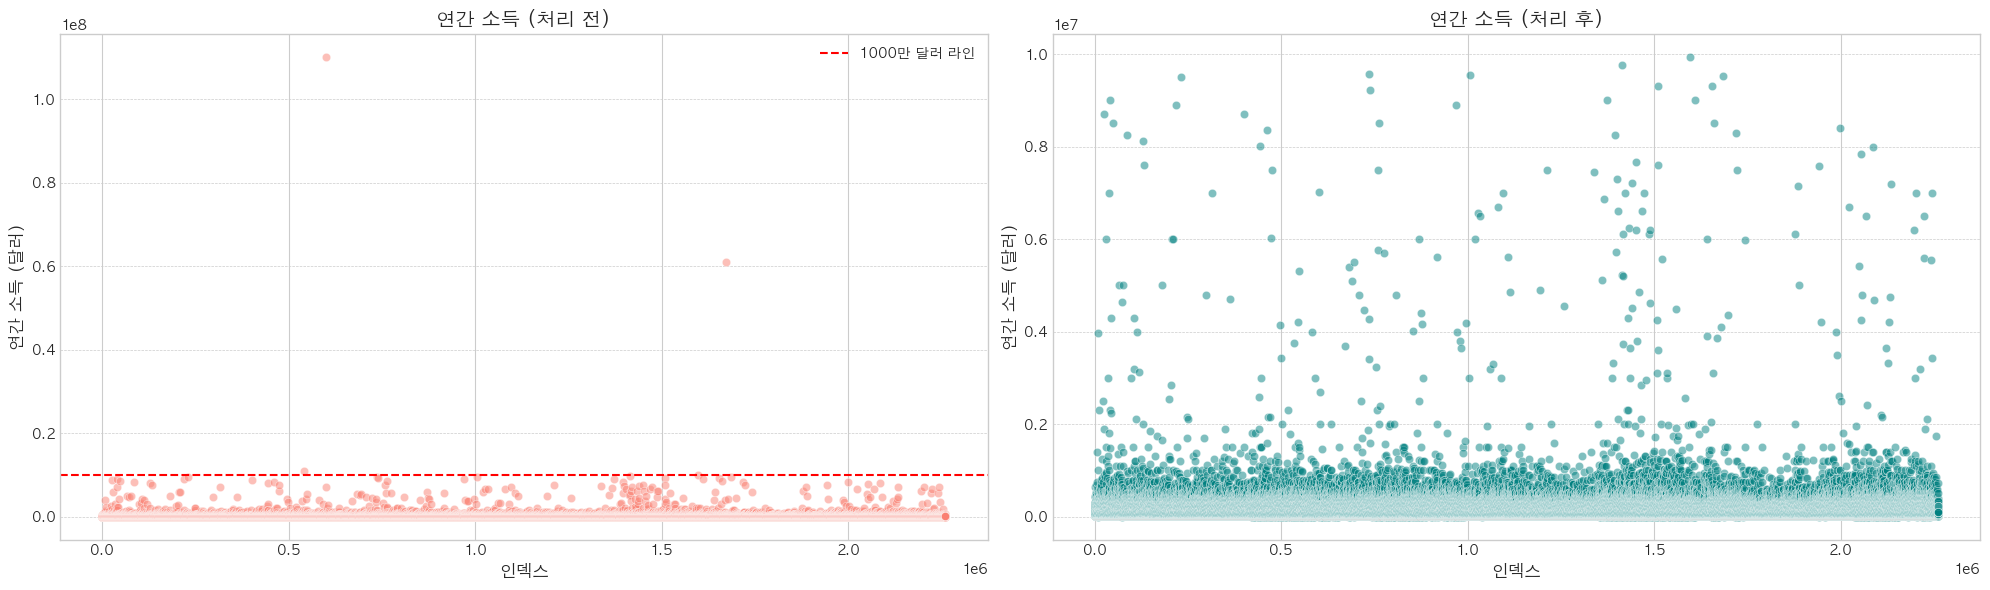

In [211]:
# 컨버스 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

### 왼쪽 산점도 (이상치 처리 전)
sns.scatterplot(x=df_analysis.index, y=df_analysis['annual_inc'], 
                alpha=0.5, color='salmon', ax=axes[0]) # ax=axes[0] : 첫 번째 칸에 그림

axes[0].set_title('연간 소득 (처리 전)', fontsize=14)
axes[0].set_ylabel('연간 소득 (달러)', fontsize=12)
axes[0].set_xlabel('인덱스', fontsize=12)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# 시각적 효과: 잘려나갈 기준선(1,000만 달러) 표시
axes[0].axhline(10000000, color='red', linestyle='--', label='1000만 달러 라인')
axes[0].legend()

###  오른쪽 산점도 (이상치 처리 후)
sns.scatterplot(x=df_cleaned.index, y=df_cleaned['annual_inc'], 
                alpha=0.5, color='teal', ax=axes[1]) # ax=axes[1] : 두 번째 칸에 그림

axes[1].set_title('연간 소득 (처리 후)', fontsize=14)
axes[1].set_ylabel('연간 소득 (달러)', fontsize=12)
axes[1].set_xlabel('인덱스', fontsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

plt.tight_layout() # 그래프간 간격 조정용도
plt.show()


<Figure size 1000x500 with 0 Axes>

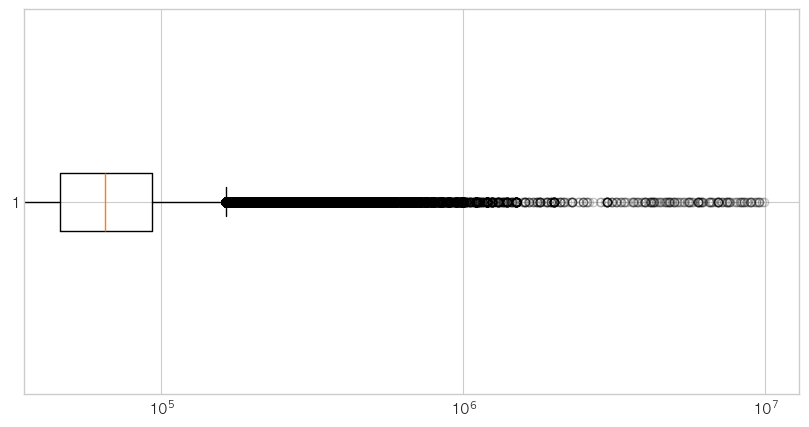

In [212]:
# 박스플랏으로 확인하였을떄도 이상치 처리 제거 잘 된점 확인 (확인용)
dplot3 = plt.figure(figsize = (10 , 5))

plt.figure(figsize=(10,5))
plt.boxplot(
    df_cleaned['annual_inc'],
    vert = False,
    flierprops = dict(marker='o', markersize=6, alpha=0.2)
)

plt.xscale('log')
plt.show()

#### 3.2 revol_util > IQR 로 이상이 제거
- 100% = 177 건
- 200% = 2 건
- IQR = 114 건 

In [213]:
# revol_util 이상치 200% 이상 기준으로 이상치 파악 

# 전체 데이터 개수
total_count = len(df_cleaned)

# 100% 이상
count_over_100 = len(df_cleaned[df_cleaned['revol_util'] > 120])   # 카드사가 갑작스레 한도를 줄이게 될경우 사용률이 뛸수 있음 / 100만원 한도 풀로 사용했는데 50만원 한도를 쓰고 있었으면 200%
pct_over_100 = (count_over_100 / total_count) * 100 # 비율 확인용

# 200% 이상
count_over_200 = len(df_cleaned[df_cleaned['revol_util'] > 200])
pct_over_200 = (count_over_200 / total_count) * 100

print(f"revol_util 전체 데이터 (총 {total_count:,}건)")
print(f"- 100% 초과 : {count_over_100:,}건 ({pct_over_100:.2f}%)") 
print(f"- 200% 초과 : {count_over_200:,}건 ({pct_over_200:.4f}%)")

revol_util 전체 데이터 (총 2,257,156건)
- 100% 초과 : 177건 (0.01%)
- 200% 초과 : 2건 (0.0001%)


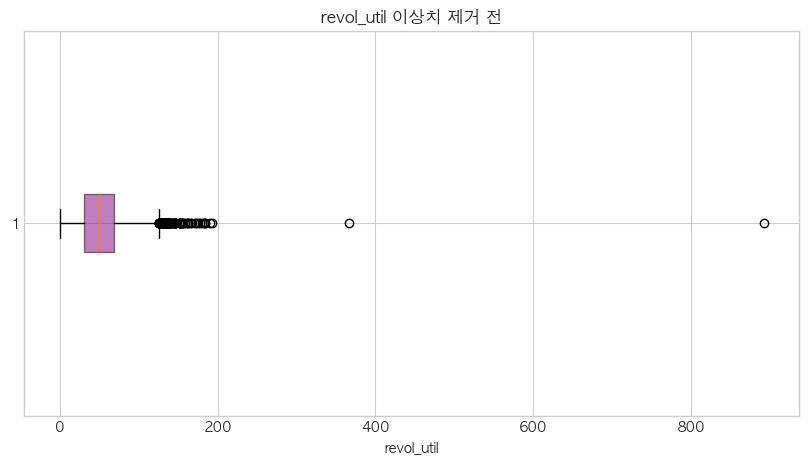

In [214]:
dplot4 = plt.figure(figsize = (10 , 5))

plt.boxplot(df_cleaned['revol_util'].values,
            vert=False,     
            patch_artist=True,        
            boxprops=dict(facecolor='purple',alpha=0.5))         
      
plt.title("revol_util 이상치 제거 전")
plt.xlabel("revol_util")
plt.show()

In [215]:
# revol_util IQR 이상치 파악

q1 = df_cleaned['revol_util'].quantile(0.25)
q3 = df_cleaned['revol_util'].quantile(0.75)

iqr = q3 - q1

print(f'----revol_util----')
print(f'- Q1 of revol_util : {q1}')
print(f'- Q3 of revol_util : {q3}')
print(f'- IQR of revol_util : {round(iqr,2)}')

----revol_util----
- Q1 of revol_util : 31.5
- Q3 of revol_util : 69.4
- IQR of revol_util : 37.9


In [216]:
lowerbound = 31.5 - (1.5 * 37.9)
upperbound = 69.4 + (1.5 * 37.9)

print('------------------')
print(f"이상치 판단 하한선: {lowerbound:.2f}")
print(f"이상치 판단 상한선: {upperbound:.2f}")

before_cnt = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['revol_util'] >= lowerbound) & (df_cleaned['revol_util'] <= upperbound)]
after_cnt = len(df_cleaned)
removed_cnt = before_cnt - after_cnt

print(f"\n--- 처리 결과 ---")
print(f"제거된 이상치 개수: {removed_cnt:,}건")
print(f"남은 데이터 개수: {after_cnt:,}건 (전체의 {after_cnt/before_cnt*100:.2f}%)")

------------------
이상치 판단 하한선: -25.35
이상치 판단 상한선: 126.25

--- 처리 결과 ---
제거된 이상치 개수: 114건
남은 데이터 개수: 2,257,042건 (전체의 99.99%)


In [217]:
# 0미만 행개수
zero_count = (df_cleaned['revol_util'] < 0).sum()

print(f"revol_util 0% 미만 : {zero_count:,}건)")

revol_util 0% 미만 : 0건)


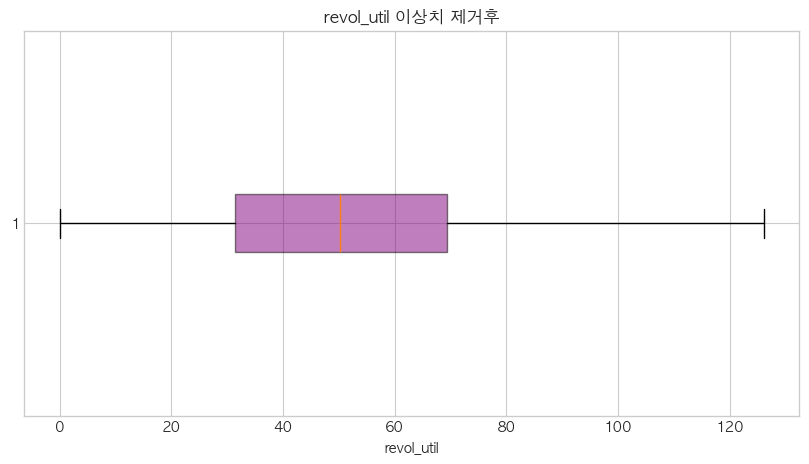

In [218]:
# revol util 이상치 제거 후
dplot4 = plt.figure(figsize = (10 , 5))

plt.boxplot(df_cleaned['revol_util'].values,
            vert=False,     
            patch_artist=True,        
            boxprops=dict(facecolor='purple',alpha=0.5))         
      
plt.title("revol_util 이상치 제거후")
plt.xlabel("revol_util")
plt.show()

#### 3.3 dti
- IQR = 21,540 건
- 100% 초과 : 2,559건
- 200% 초과 : 834건

In [219]:
# dti (음수제거) > dti 가 음수일수는 없음
df_cleaned = df_cleaned[df_cleaned['dti'] >= 0]

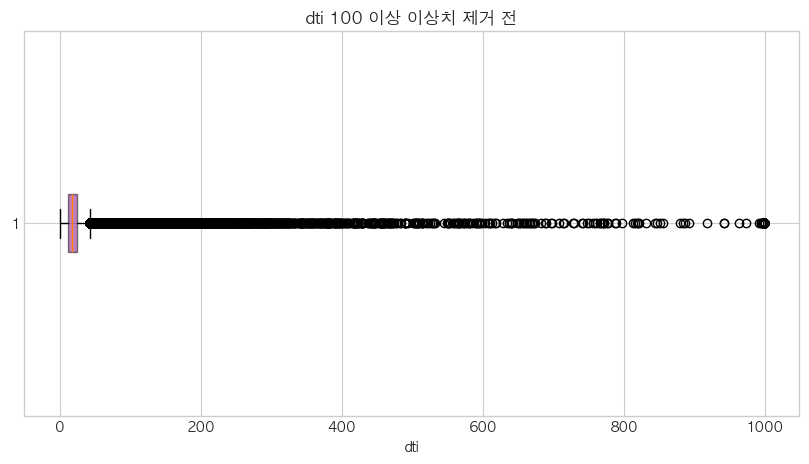

In [220]:
dplot4 = plt.figure(figsize = (10 , 5))
plt.rc('font', family='AppleGothic') 

plt.boxplot(df_cleaned['dti'].values,
            vert=False,     
            patch_artist=True,        
            boxprops=dict(facecolor='purple',alpha=0.5))         
      
plt.title("dti 100 이상 이상치 제거 전")
plt.xlabel("dti")
plt.show()

In [221]:
# dti IQR 파악
q1 = df_cleaned['dti'].quantile(0.25)
q3 = df_cleaned['dti'].quantile(0.75)

iqr = q3 - q1

print(f'----dti----')
print(f'- Q1 of dti : {q1}')
print(f'- Q3 of dti : {round(q3,1)}')
print(f'- IQR of dti : {round(iqr,1)}')

----dti----
- Q1 of dti : 11.9
- Q3 of dti : 24.5
- IQR of dti : 12.6


In [222]:
lowerbound = 11.9 - (1.5 * 12.6)
upperbound = 24.5 + (1.5 * 12.6)

print('------------------')
print(f"이상치 판단 하한선: {lowerbound:.2f}")
print(f"이상치 판단 상한선: {upperbound:.2f}")

before_cnt = len(df_cleaned)
after_cnt = len(df_cleaned[(df_cleaned['dti'] >= lowerbound) & (df_cleaned['dti'] <= upperbound)])
removed_cnt = before_cnt - after_cnt

print(f"\n--- IQR 진행시 ---")
print(f"제거 대상 이상치 개수: {removed_cnt:,}건")
print(f"남은 데이터 개수: {after_cnt:,}건 (전체의 {after_cnt/before_cnt*100:.2f}%)")

------------------
이상치 판단 하한선: -7.00
이상치 판단 상한선: 43.40

--- IQR 진행시 ---
제거 대상 이상치 개수: 21,540건
남은 데이터 개수: 2,235,500건 (전체의 99.05%)


In [223]:
# dti 이상치 200% 이상 기준으로 이상치 파악 

# 전체 데이터 개수
total_count = len(df_cleaned)

# 100% 이상
count_over_100 = len(df_cleaned[df_cleaned['dti'] > 100])   
pct_over_100 = (count_over_100 / total_count) * 100 # 비율 확인용

# 200% 이상
count_over_200 = len(df_cleaned[df_cleaned['dti'] > 200])
pct_over_200 = (count_over_200 / total_count) * 100

print(f"dti 전체 데이터 (총 {total_count:,}건)")
print(f"- 100% 초과 : {count_over_100:,}건 ({pct_over_100:.2f}%)") 
print(f"- 200% 초과 : {count_over_200:,}건 ({pct_over_200:.4f}%)")
print(f'총 합계: {count_over_100+count_over_200:,}건')

dti 전체 데이터 (총 2,257,040건)
- 100% 초과 : 2,559건 (0.11%)
- 200% 초과 : 834건 (0.0370%)
총 합계: 3,393건


In [224]:
# dti 상한선 100

df_cleaned.loc[df_cleaned['dti']>100,'dti']=100

df.loc[df['dti'] > 100].nunique()

id                       2561
member_id                   0
loan_amnt                 392
funded_amnt               392
funded_amnt_inv           433
                         ... 
settlement_status           3
settlement_date             8
settlement_amount          10
settlement_percentage       9
settlement_term             5
Length: 151, dtype: int64

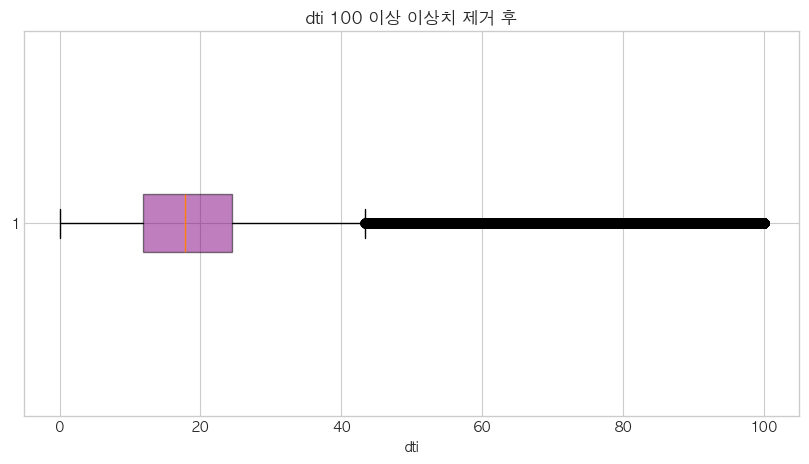

In [225]:
dplot4 = plt.figure(figsize = (10 , 5))
plt.rc('font', family='AppleGothic') 

plt.boxplot(df_cleaned['dti'].values,
            vert=False,     
            patch_artist=True,        
            boxprops=dict(facecolor='purple',alpha=0.5))         
      
plt.title("dti 100 이상 이상치 제거 후")
plt.xlabel("dti")
plt.show()

##### 4. peb_rec (공공 기록)

- 오른쪽 꼬리가 엄청길고 중간에 이상한 값(40,80)등 튀어나와있음
- 클리핑(상한선) 기준을 99.5%인 3회로 잡고 그보다 큰값은 3회로 변환

In [226]:
print(f"최대값: {df_cleaned['pub_rec'].max()}")
print("상위 10개 값 빈도수:")
print(df_cleaned['pub_rec'].value_counts().sort_index(ascending=False).head(10))

최대값: 86.0
상위 10개 값 빈도수:
pub_rec
86.0    1
63.0    1
61.0    2
54.0    1
52.0    1
49.0    2
47.0    1
46.0    1
45.0    1
44.0    1
Name: count, dtype: int64


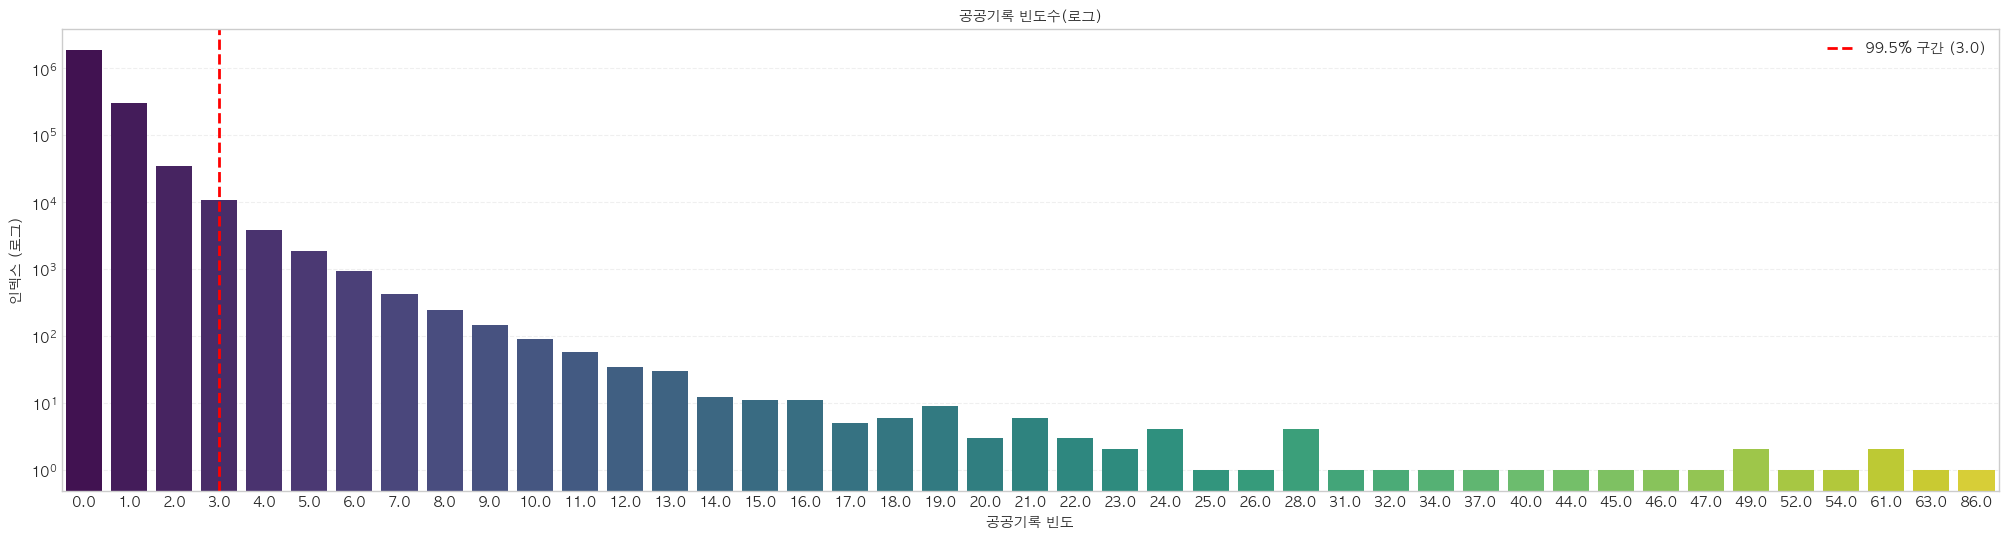

In [227]:
pub_rec_counts = df_cleaned['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(25, 6))

# 바플롯(bar)
pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')

# y스케일을 로그로해야 잘 보인다고하네요
plt.yscale('log')

# 기준선은 99.5
limit_995 = df_cleaned['pub_rec'].quantile(0.995)
# 약간의 보정
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')


plt.title('공공기록 빈도수(로그)', fontsize=10)
plt.xlabel('공공기록 빈도', fontsize=10)
plt.ylabel('인덱스 (로그)', fontsize=10)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

- 상위 99.5%값으로 클리핑
- pub_rec 상한선 적용값: 3.0회

In [228]:
# 1. Pub_rec: 상위 99.5% 값으로 클리핑
limit_995 = df_cleaned['pub_rec'].quantile(0.995) # 분위수(0.995)
df_cleaned['pub_rec'] = df_cleaned['pub_rec'].clip(upper=limit_995) 
print(f"pub_rec 상한선 적용값: {limit_995}회") # 횟수 확인

pub_rec 상한선 적용값: 3.0회


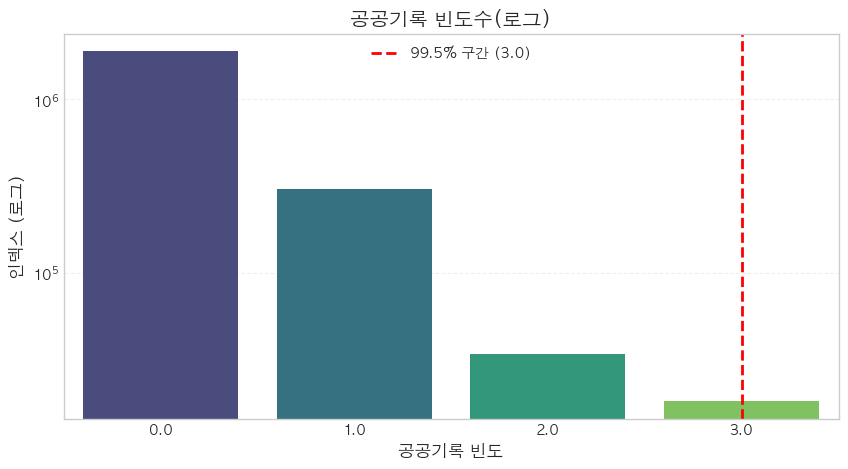

In [229]:
pub_rec_counts = df_cleaned['pub_rec'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rc('font', family='AppleGothic') 

pub_rec_plot = sns.barplot(x=pub_rec_counts.index, y=pub_rec_counts.values, palette='viridis')
plt.yscale('log')
limit_995 = df_cleaned['pub_rec'].quantile(0.995)
plt.axvline(x=limit_995, color='red', linestyle='--', linewidth=2, label=f'99.5% 구간 ({limit_995})')

plt.title('공공기록 빈도수(로그)', fontsize=14)
plt.xlabel('공공기록 빈도', fontsize=12)
plt.ylabel('인덱스 (로그)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

#### 4. 파생변수, 라벨 인코딩 및 데이터 수치 일치화

##### 4.1 loan_status (라벨 인코딩)

In [230]:
# 컬럼 확인 loan_status 
df_cleaned['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [231]:
df_cleaned.shape

(2257040, 13)

In [232]:
# 라벨 인코딩 : loan_status > loan_status_binary
# Fully Paid: 완전 상환
# Charged Off: 상각/부도 처리

target_status = ['Fully Paid', 'Charged Off']

df_cleaned = df_cleaned[df_cleaned['loan_status'].isin(target_status)]

loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1
}

df_cleaned['loan_status_binary'] = df_cleaned['loan_status'].map(loan_status_mapping)

In [233]:
df_cleaned.shape

(1344001, 14)

##### 4.2 grade (라벨 인코딩)

In [234]:
# 대출 등급 라벨 인코딩 
# A(우량) = 1점 ~ G(위험) = 7점 (숫자가 클수록 위험함)
grade_dic = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_cleaned['grade_num'] = df_cleaned['grade'].map(grade_dic)

##### 4.3 home_ownership (라벨 인코딩)

In [235]:
# 주택 소유 상태 라벨 인코딩 
# home_ownership: 'MORTGAGE',  'OWN' 소유, 'ANY', 'RENT' ,'NONE', 'OTHER' 미소유

map_home_ownership = {
    'MORTGAGE': 0, 'OWN':0 , 
    'ANY':1,'RENT': 1, 'NONE': 1, 'OTHER' : 1
}
home_ownership_binary = df_cleaned['home_ownership'].map(map_home_ownership)
df_cleaned['home_ownership_binary']=home_ownership_binary
df_cleaned.drop('home_ownership', axis=1, inplace=True)

##### 4.4 LTI Loan to Income (파생변수)

In [236]:
# 파생 변수 : LTI (대출 금액/연소득)
df_cleaned['LTI'] = round(df_cleaned['loan_amnt'] /df_cleaned['annual_inc'],2)

##### 4.5 term (일치화 작업)

In [ ]:
# 대출 기간 term 컬럼 / months 제거 후 int로 변경

df_cleaned['term'] = df_cleaned['term'].str.extract('(\d+)').astype(int)

In [238]:
df_cleaned.head()

,loan_status,annual_inc,dti,fico_range_low,revol_util,delinq_2yrs,pub_rec,loan_amnt,int_rate,term,purpose,grade,loan_status_binary,grade_num,home_ownership_binary,LTI
0,Fully Paid,55000.0,5.91,675.0,29.7,0.0,0.0,3600.0,13.99,36,debt_consolidation,C,0,3,0,0.07
1,Fully Paid,65000.0,16.06,715.0,19.2,1.0,0.0,24700.0,11.99,36,small_business,C,0,3,0,0.38
2,Fully Paid,63000.0,10.78,695.0,56.2,0.0,0.0,20000.0,10.78,60,home_improvement,B,0,2,0,0.32
4,Fully Paid,104433.0,25.37,695.0,64.5,1.0,0.0,10400.0,22.45,60,major_purchase,F,0,6,0,0.10
5,Fully Paid,34000.0,10.20,690.0,68.4,0.0,0.0,11950.0,13.44,36,debt_consolidation,C,0,3,1,0.35


#### 통계 분석

In [239]:
# 폰트 설정 (사용하는 OS에 설치된 한글 폰트 이름을 사용합니다)
# 예: Windows의 'Malgun Gothic', Mac의 'AppleGothic', Colab/Linux의 'NanumGothic' 등
plt.rc('font', family='AppleGothic') 

# 마이너스 기호 깨짐 방지 (꼭 함께 설정해 주세요)
plt.rcParams['axes.unicode_minus'] = False

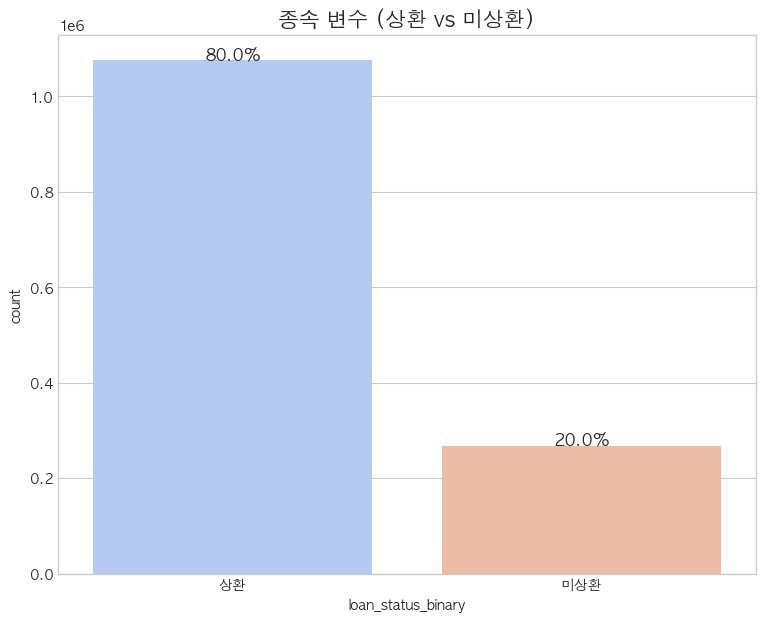

In [240]:
plt.figure(figsize=(9, 7))
plt.rc('font', family='AppleGothic') 

# 카운트플롯 사용
ax = sns.countplot(x='loan_status_binary', data=df_cleaned, palette='coolwarm')

# 그래프 위에 비율 표시하는 방법
total = len(df_cleaned) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1000, 
            f'{height/total:.1%}', ha="center", fontsize=12)

ax.set_xticklabels(['상환', '미상환'])
plt.title('종속 변수 (상환 vs 미상환)', fontsize=15)
plt.show()

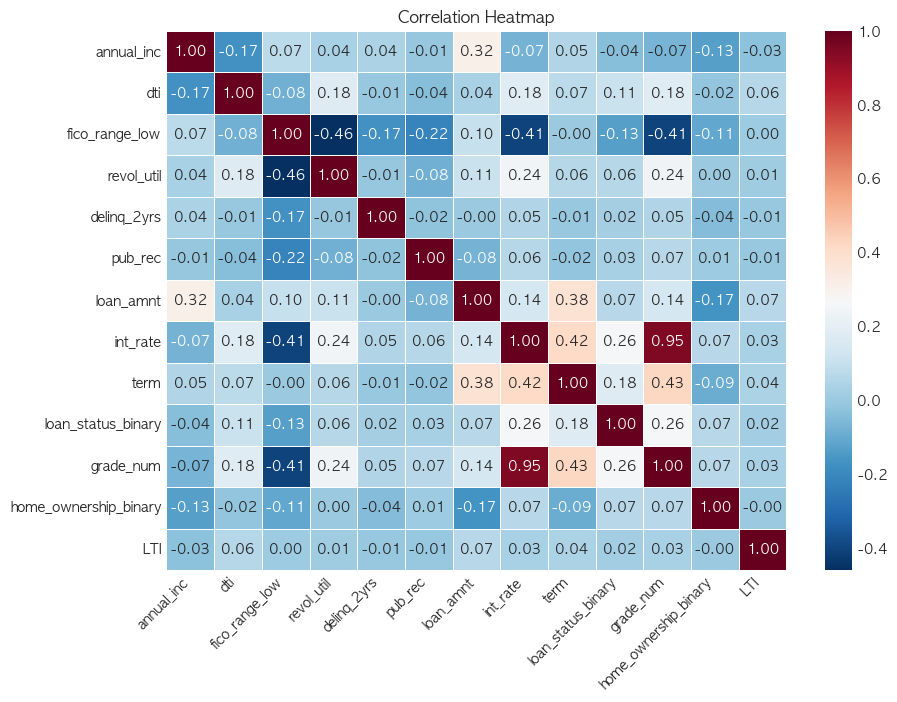

In [241]:
dplot = df_cleaned.corr(numeric_only=True)

plt.figure(figsize = (10,7))

dplot = sns.heatmap(dplot,
                    annot=True, 
                    cmap='RdBu_r',   
                    linewidths=0.5,
                    fmt=".2f")

plt.rcParams['axes.unicode_minus'] = False
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

### 가설검정
1. 이자율
2. LTI
3. revol_util

In [242]:
# 가설 2 - 이자율

H0_int = "귀무가설(H0): 완납자와 연체자 그룹 간의 평균 이자율 차이가 없다."
H1_int = "대립가설(H1): 완납자와 연체자 그룹 간의 평균 이자율 차이가 존재한다."

print(H0_int)
print(H1_int)

귀무가설(H0): 완납자와 연체자 그룹 간의 평균 이자율 차이가 없다.
대립가설(H1): 완납자와 연체자 그룹 간의 평균 이자율 차이가 존재한다.


[Text(0, 0, '상환'), Text(1, 0, '미상환')]

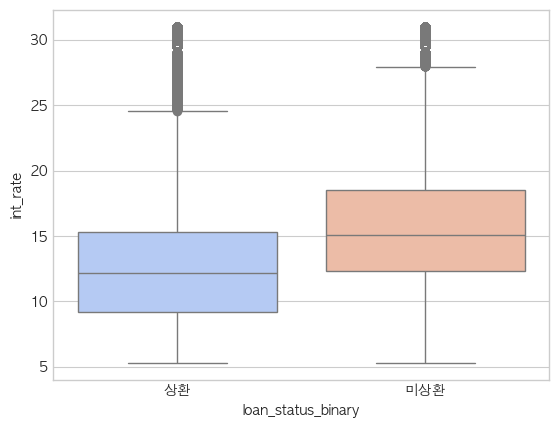

In [243]:
# loan_status_binary 별 int_rate (미상환 고객일수록 이율이 세다)
# sns.boxplot(x="loan_status_binary", y="int_rate", data=df_clean2)
ax = sns.boxplot(x="loan_status_binary", y="int_rate", data=df_cleaned, palette='coolwarm')
# x축 눈금 라벨 변경
ax.set_xticklabels(['상환', '미상환'])

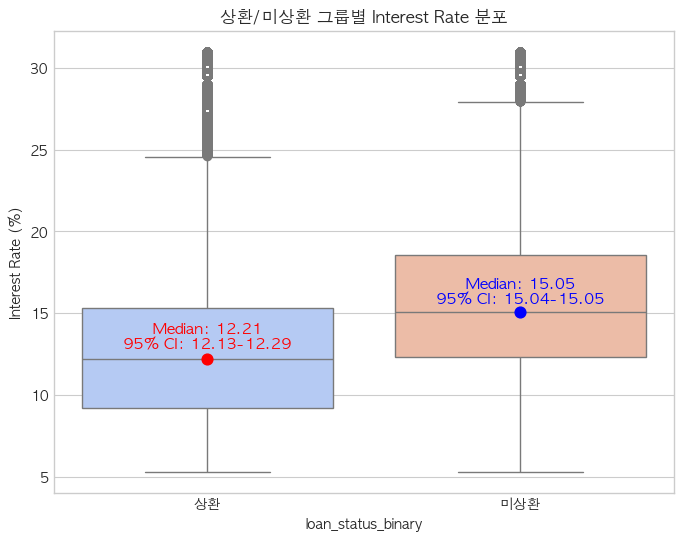

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 부트스트랩 함수 (median CI)
# ------------------------------
def bootstrap_median_ci(data, n_boot=10, ci=95):
    boot_meds = []
    n = len(data)
    
    for _ in range(n_boot):
        sample = np.random.choice(data, size=n, replace=True)  # 복원추출
        boot_meds.append(np.median(sample))
        
    lower = np.percentile(boot_meds, (100 - ci) / 2)
    upper = np.percentile(boot_meds, 100 - (100 - ci) / 2)
    return lower, upper

# ------------------------------
# int_rate 데이터 분리
# ------------------------------
int_rate_repaid_values = df_cleaned[df_cleaned['loan_status_binary'] == 0]['int_rate'].values
int_rate_default_values = df_cleaned[df_cleaned['loan_status_binary'] == 1]['int_rate'].values

# 중앙값 계산
median_int_rate_repaid = np.median(int_rate_repaid_values)
median_int_rate_default = np.median(int_rate_default_values)

# 부트스트랩 CI 계산
lower_int_rate_repaid, upper_int_rate_repaid = bootstrap_median_ci(int_rate_repaid_values, n_boot=10, ci=95)
lower_int_rate_default, upper_int_rate_default = bootstrap_median_ci(int_rate_default_values, n_boot=10, ci=95)

# ------------------------------
# 박스플롯
# ------------------------------
plt.figure(figsize=(8,6))
sns.boxplot(x='loan_status_binary', y='int_rate', data=df_cleaned, palette='coolwarm')
plt.xticks([0,1], ['상환', '미상환'])
plt.ylabel('Interest Rate (%)')
plt.title('상환/미상환 그룹별 Interest Rate 분포')

# 중앙값 점 표시
plt.scatter(0, median_int_rate_repaid, color='red', s=60, zorder=5)
plt.scatter(1, median_int_rate_default, color='blue', s=60, zorder=5)

# 부트스트랩 CI 선 표시
plt.plot([0,0], [lower_int_rate_repaid, upper_int_rate_repaid], color='red', linewidth=3, zorder=4)
plt.plot([1,1], [lower_int_rate_default, upper_int_rate_default], color='blue', linewidth=3, zorder=4)

# 중앙값 + CI 텍스트 표시
plt.text(0, upper_int_rate_repaid + 0.5, 
         f'Median: {median_int_rate_repaid:.2f}\n95% CI: {lower_int_rate_repaid:.2f}-{upper_int_rate_repaid:.2f}', 
         color='red', ha='center', fontsize=11)
plt.text(1, upper_int_rate_default + 0.5, 
         f'Median: {median_int_rate_default:.2f}\n95% CI: {lower_int_rate_default:.2f}-{upper_int_rate_default:.2f}', 
         color='blue', ha='center', fontsize=11)

plt.show()

In [245]:
# 종속변수 loan_status_binary (이진형) 독립변수 int_rate(연속형) , 양측검정
import pandas as pd
from scipy.stats import pointbiserialr

# Point-Biserial 상관 계산
corr, p_value = pointbiserialr(df_cleaned['loan_status_binary'], df_cleaned['int_rate'])

print("----int_rate vs loan_status_binary----")
print(f"상관계수 (r): {corr:.4f}")
print(f"p-value: {p_value:.4f}")

# 상환/미상환 그룹 중앙값 확인
median_values = df_cleaned.groupby('loan_status_binary')['int_rate'].median()
print('-------------------------', '\n')
print("그룹별 int_rate 중앙값:")
print(median_values)

# =>p-value<0.01 유의미한 상관 귀무가설 기각
# r=0.25 약한 양의 상관 미상환자의 이율이 높은 경향
# 중앙값 차이: 상환 그룹은 12%, 미상환 그룹은 15%

----int_rate vs loan_status_binary----
상관계수 (r): 0.2588
p-value: 0.0000
------------------------- 

그룹별 int_rate 중앙값:
loan_status_binary
0    12.21
1    15.05
Name: int_rate, dtype: float64


In [246]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) 이자율 구간 설정 (1% 간격)
bins = np.arange(df_cleaned['int_rate'].min(), df_cleaned['int_rate'].max() + 1, 1)

# 2) 구간별 구분
df_cleaned['int_rate_bin'] = pd.cut(df_cleaned['int_rate'], bins)

# 3) 각 구간별 미상환 확률 계산
default_rate_by_bin = df_cleaned.groupby('int_rate_bin')['loan_status_binary'].mean()

# 4) 구간 중앙값 계산
bin_centers = pd.IntervalIndex(default_rate_by_bin.index).mid.astype(float).tolist()

In [247]:
# 데이터 추출 (NaN 제외)
valid_idx = ~np.isnan(default_rate_by_bin.values)
x_coords = np.array(bin_centers)[valid_idx]
y_coords = default_rate_by_bin.values[valid_idx]

# 부도율 0.5인 지점의 이자율(x) 계산 (보간법)
target_y = 0.494
if y_coords.max() >= target_y:
    # y_coords에서 0.5가 되는 x값을 추정
    exact_x = np.interp(target_y, y_coords, x_coords)
    print(f"부도율이 정확히 49%가 되는 추정 이자율: {exact_x:.2f}%")
else:
    print("데이터 내에 부도율이 49%에 도달하는 구간이 없습니다.")
    exact_x = None

부도율이 정확히 49%가 되는 추정 이자율: 26.79%


부도율 확률이 0.49 이상인 이자율 구간 (중앙값)과 부도율 확률:
이자율: 27.81%, 부도율 : 56.15%
이자율: 28.81%, 부도율 : 50.38%


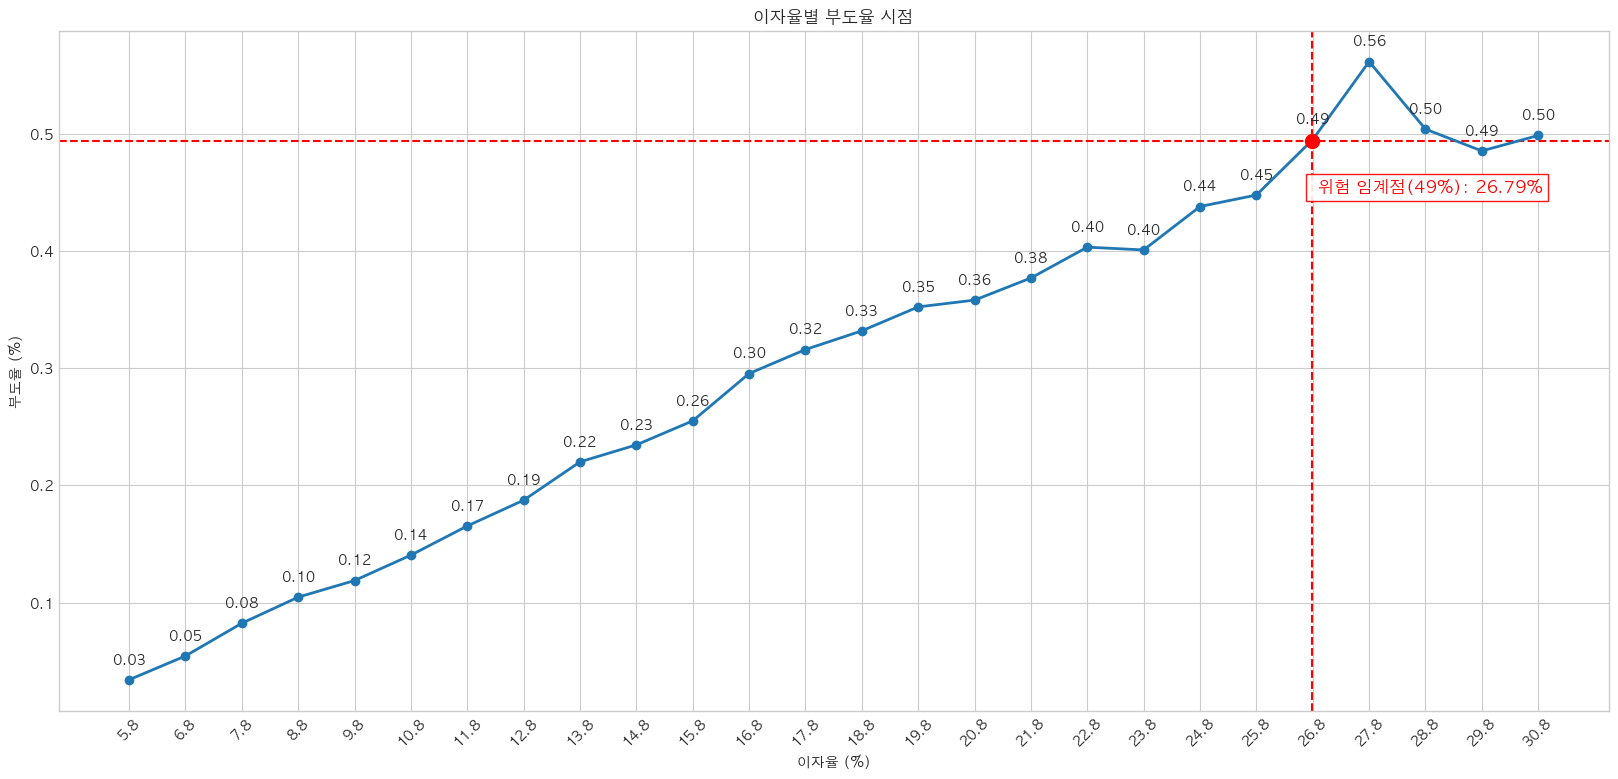

In [248]:
plt.figure(figsize=(20, 10)) # 가로 길이를 조금 늘려 가독성 확보
plt.plot(bin_centers, default_rate_by_bin.values, marker='o', color='#1f77b4', linewidth=2)

for x, y in zip(bin_centers, default_rate_by_bin.values):
    if not np.isnan(y):
        plt.text(x, y + 0.011, f'{y:.2f}', fontsize=10, ha='center', va='bottom', fontweight='bold')

plt.xlabel('이자율 (%)')
plt.ylabel('부도율 (%)')
plt.title('이자율별 부도율 시점')
plt.grid(True)
plt.subplots_adjust(bottom=0.2)
plt.xticks(bin_centers, [f'{x:.1f}' for x in bin_centers], rotation=45)

plt.axhline(y=0.494, color='red', linestyle='--', linewidth=1.5, zorder=1)
plt.axvline(x=exact_x, color='red', linestyle='--', linewidth=1.5, zorder=1)
plt.plot(exact_x, 0.494, 'ro', markersize=10, zorder=5)
plt.text(exact_x+0.005,0.49-0.04, f' 위험 임계점(49%): {exact_x:.2f}%', 
             color='red', fontweight='bold', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='red'))

# 6) 미상환 확률 0.49 이상인 구간 출력
threshold = 0.5
exceed_bins = [(center, rate) for center, rate in zip(bin_centers, default_rate_by_bin.values) if rate >= threshold]

print("부도율 확률이 0.49 이상인 이자율 구간 (중앙값)과 부도율 확률:")
for center, rate in exceed_bins:
    print(f"이자율: {center:.2f}%, 부도율 : {rate*100:.2f}%")

#   약 26~27% 구간부터 미상환 확률이 49% 이상으로 급증한다
# → 이자율 신청은 자동 거절하거나 추가 심사
# 이자율이 26.8% 넘는 대출은 부실 위험이 높습니다” 라는 식으로 투자자에게 리스크 경고

금리는 차주의 종합 위험이 이미 반영된 결과 변수이고,
이 금리를 ‘위험 구간을 구분하는 기준점’으로 활용한 뒤,
해당 구간 내부에서 
중·장기적인 상환 구조의 지속 가능성은 DTI를 통해,
단기적인 유동성 여력은 revolving utilization을 통해
각각 분리하여 점검하는 구조로 심사를 구성한다.

상태지표 갚을 능력이 있는가 (중장기적 관점) DTI = 부채상환액/연소득

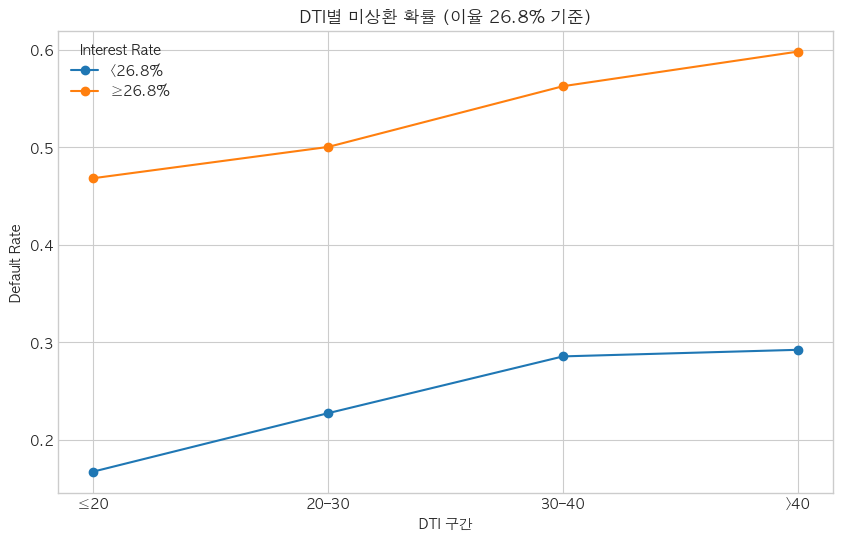

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_cleaned.copy()

# 이율 기준 그룹
df['rate_grp'] = pd.cut(
    df['int_rate'],
    bins=[0, 26.8, 100],
    labels=['<26.8%', '≥26.8%']
)

#  DTI 구간 생성 
dti_bins = [0, 20, 30, 40, 100]
dti_labels = ['≤20', '20–30', '30–40', '>40']

df['dti_grp'] = pd.cut(
    df['dti'],
    bins=dti_bins,
    labels=dti_labels,
    right=False
)

# 그룹별 미상환 확률 계산
dti_rate = (
    df.groupby(['rate_grp', 'dti_grp'])['loan_status_binary']
      .mean()
      .reset_index()
)

# 그래프
plt.figure(figsize=(10,6))

for rate in dti_rate['rate_grp'].unique():
    sub = dti_rate[dti_rate['rate_grp'] == rate]
    plt.plot(
        sub['dti_grp'],
        sub['loan_status_binary'],
        marker='o',
        label=rate
    )

plt.xlabel('DTI 구간')
plt.ylabel('Default Rate')
plt.title('DTI별 미상환 확률 (이율 26.8% 기준)')
plt.legend(title='Interest Rate')
plt.grid(True)
plt.show()

# 분석 결과, 이자율이 26.8% 이상인 대출은
# DTI 전 구간에서 미상환 확률이 더 높게 나타났으며,
# 특히 DTI 30%를 초과하는 시점부터
# 미상환 확률이 급격히 상승하였다.
# 이는 해당 대출을 포함한 총 상환 부담이
# 소득 대비 과도한 구조였기 때문으로 해석된다

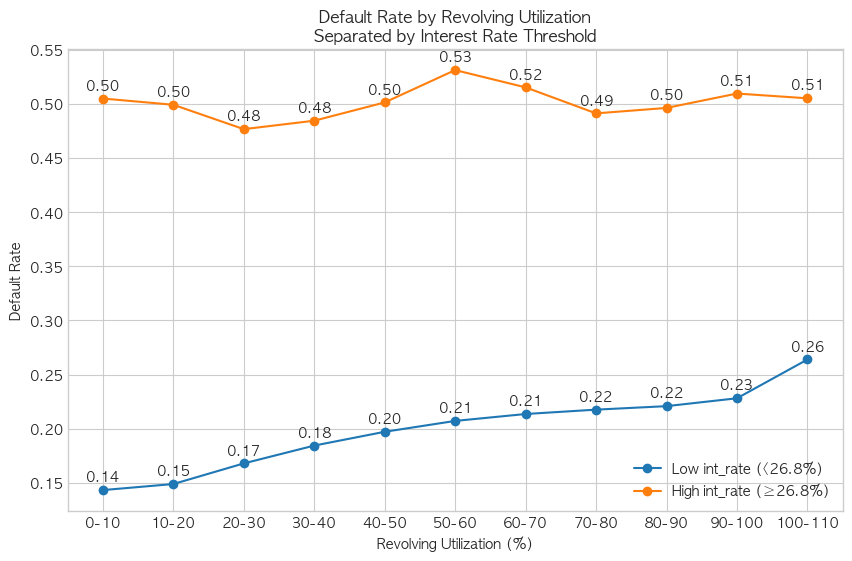

In [250]:
# revol_util 구간 생성 (10 단위) + 라벨 직접 지정
revol_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,110]
revol_labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110']

df['revol_grp'] = pd.cut(df['revol_util'], bins=revol_bins, labels=revol_labels, right=False)

# 그룹별 미상환 확률 계산
revol_rate = df.groupby(['revol_grp','rate_grp'])['loan_status_binary'].mean().unstack('rate_grp')

# 시각화 
plt.figure(figsize=(10,6))
plt.plot(revol_rate.index, revol_rate['<26.8%'], marker='o', label='Low int_rate (<26.8%)')
plt.plot(revol_rate.index, revol_rate['≥26.8%'], marker='o', label='High int_rate (≥26.8%)')

# 각 점 위에 숫자 표시
for col in revol_rate.columns:
    for x, y in zip(revol_rate.index, revol_rate[col]):
        plt.text(x, y + 0.008, f'{y:.2f}', ha='center')  

plt.xlabel('Revolving Utilization (%)')
plt.ylabel('Default Rate')
plt.title('Default Rate by Revolving Utilization\nSeparated by Interest Rate Threshold')
plt.legend()
plt.grid(True)
plt.show()

# 사용률이 증가할수록 미상환 확률이 완만하지만 일관되게 상승하는 추세가 확인되었다.

이율을 미상환 위험이 급증하는 임계점을 기준으로
위험 구간을 설정한 뒤,
해당 구간 내부의 위험 구성을
중·장기 상환 구조(DTI)와
단기 유동성 지표(revolving utilization)로 단계적으로 확인

고금리 차주 심사 시
DTI를 통한 구조적 리스크 인식 이후,
revolving utilization을 중심으로 한
단기 리스크 점검이
실질적인 판단 보완 수단이 될 수 있음을 의미

사후 관리
다만 이러한 구조적 위험은
대출 실행 이후 차주의 행동 변화에 따라
더 빠르게 현실화될 수 있으므로,
사후 단계에서는 revolving utilization의 변화를
조기 경보 지표로 활용한 관리 전략 필요

In [251]:
# 가설 3 - LTI

H0_LTI = '귀무가설(H0): 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 없다.'
H1_LTI = '대립가설(H1): 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 있다.'

print(H0_LTI)
print(H1_LTI)

귀무가설(H0): 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 없다.
대립가설(H1): 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 있다.


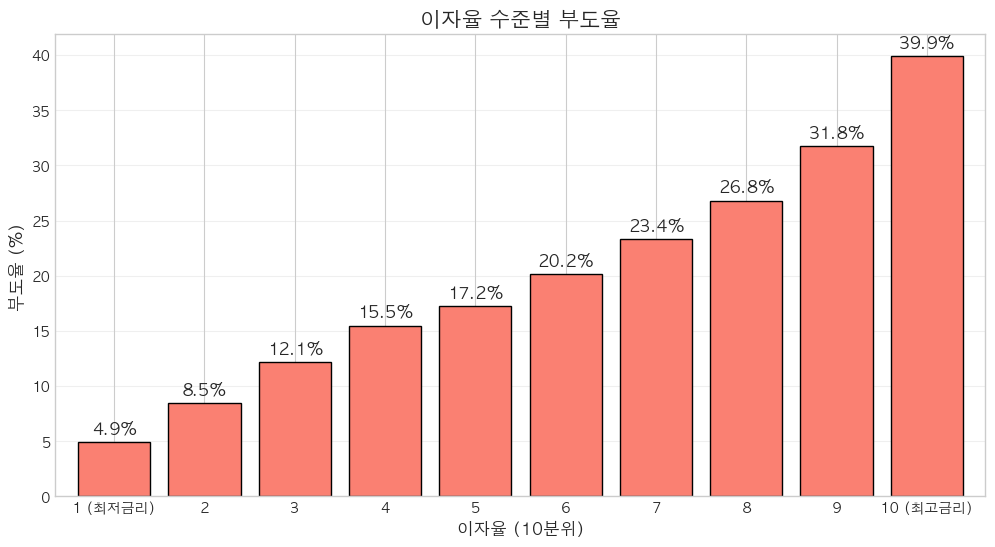

In [272]:
# 10개 분위수로 나누고 1~10 까지 라벨링
labels = ['1 (최저금리)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (최고금리)']
df_cleaned['int_bin'] = pd.qcut(df_cleaned['int_rate'], 10, labels=labels)

# 구간별 부도율 계산
risk = df_cleaned.groupby('int_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
ax = risk.plot(kind='bar', color= 'salmon' , edgecolor='black', width=0.8)

# 퍼센테이지 표시
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(x = p.get_x() + p.get_width() / 2, 
                y = height + 0.5, 
                s = f'{height:.1f}%', 
                ha = 'center', va = 'bottom', 
                fontsize = 12, fontweight = 'bold')

plt.title('이자율 수준별 부도율', fontsize=15)
plt.xlabel('이자율 (10분위)', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

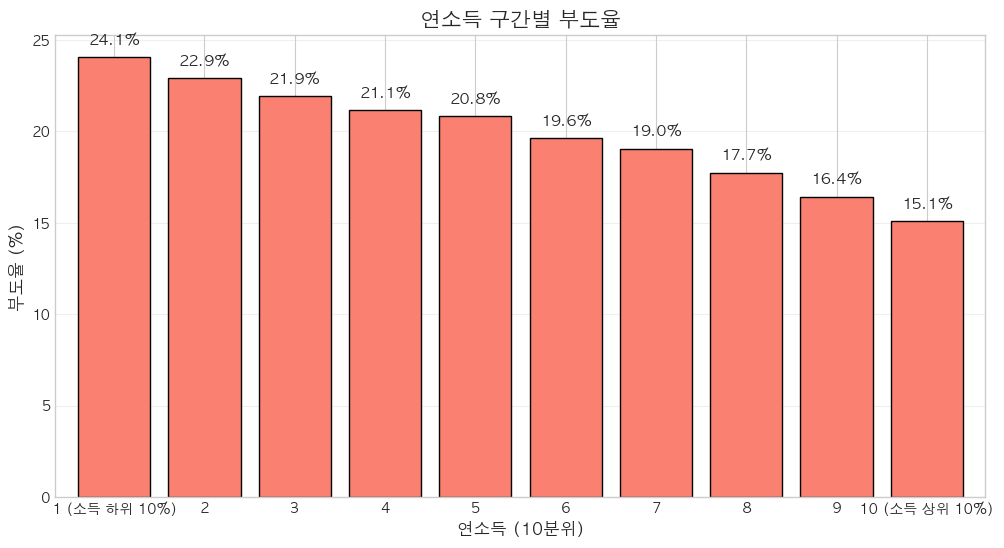

In [273]:
# 연소득 10개 분위수로 나눠 보기
inc_labels = ['1 (소득 하위 10%)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (소득 상위 10%)']
df_cleaned['inc_bin'] = pd.qcut(df_cleaned['annual_inc'], 10, labels=inc_labels)

# 구간별 부도율 계산
inc_risk = df_cleaned.groupby('inc_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
ax = inc_risk.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

# 퍼센테이지 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width() / 2, 
            y = height + 0.5, 
            s = f'{height:.1f}%', 
            ha = 'center', va = 'bottom', 
            fontsize = 11, fontweight = 'bold')

plt.title('연소득 구간별 부도율', fontsize=15)
plt.xlabel('연소득 (10분위)', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.show()

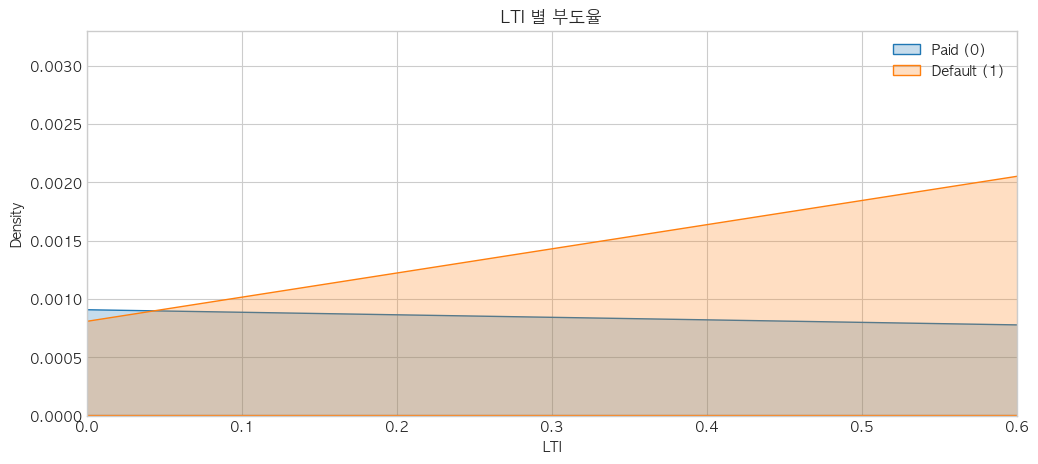

In [252]:
plt.figure(figsize=(12, 5))
sns.kdeplot(df_cleaned[df_cleaned['loan_status_binary']==0]['LTI'], label='Paid (0)', shade=True)
sns.kdeplot(df_cleaned[df_cleaned['loan_status_binary']==1]['LTI'], label='Default (1)', shade=True)
plt.xlim(0, 0.6) 
plt.title('LTI 별 부도율')
plt.legend()
plt.show()

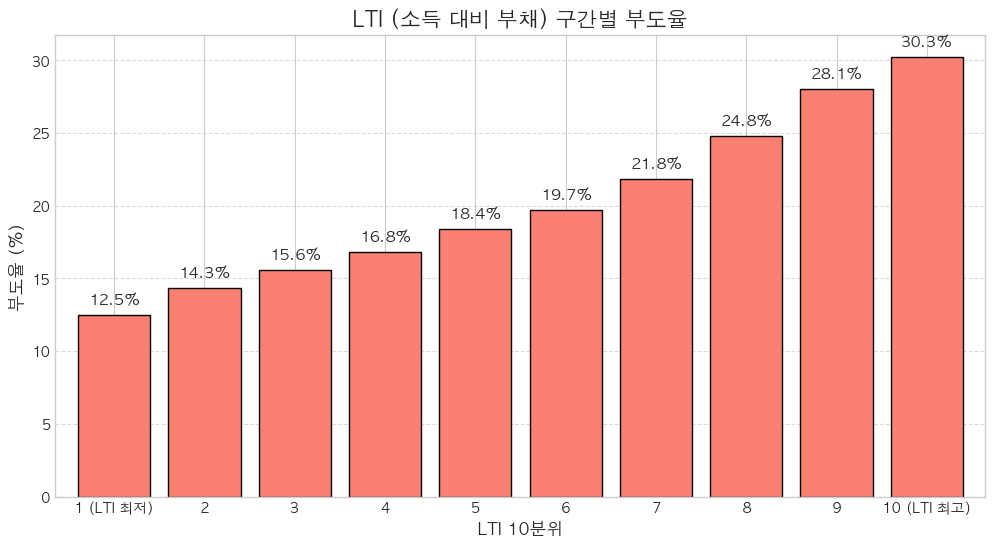

In [253]:
# 10분위로 나누기
labels = ['1 (LTI 최저)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (LTI 최고)']

df_cleaned['LTI_bin'] = pd.qcut(df_cleaned['LTI'], 10, labels=labels)

# 구간별 부도율 계산
lti = df_cleaned.groupby('LTI_bin')['loan_status_binary'].mean() * 100

plt.figure(figsize=(12, 6))
lti.plot(kind='bar', color='salmon', edgecolor='black', width=0.8)

plt.title('LTI (소득 대비 부채) 구간별 부도율', fontsize=15)
plt.xlabel('LTI 10분위', fontsize=12)
plt.ylabel('부도율 (%)', fontsize=12)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 코드 표시
for i, v in enumerate(lti):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.show()

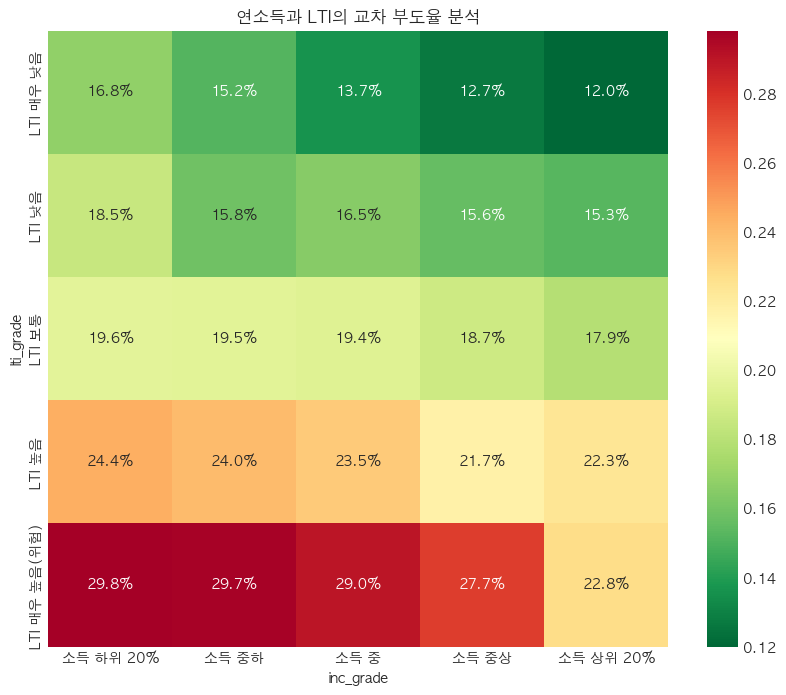

In [274]:
# 1. 연소득과 LTI를 10분위로 나누기
df_cleaned['inc_grade'] = pd.qcut(df_cleaned['annual_inc'], 5, labels=['소득 하위 20%', '소득 중하', '소득 중', '소득 중상', '소득 상위 20%'])
df_cleaned['lti_grade'] = pd.qcut(df_cleaned['LTI'], 5, labels=['LTI 매우 낮음', 'LTI 낮음', 'LTI 보통', 'LTI 높음', 'LTI 매우 높음(위험)'])

# 2. 피벗 테이블 생성 --> 각 구간별 부도율 계산용도
heatmap_data = df_cleaned.pivot_table(index=   'lti_grade', columns='inc_grade', values='loan_status_binary', aggfunc='mean')

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn_r') # 붉은색일수록 위험함
plt.title('연소득과 LTI의 교차 부도율 분석')
plt.show()

- [파생 변수]
- LTI(연봉대비 대출금) 별 평균 부도율
- 부도율 그룹(1)의 LTI가 정상 상환자 그룹(0)보다 약 20%나 더 높다 (0.04 / 0.21 ≒ 19.7%)

In [275]:
print(df_cleaned.groupby('loan_status_binary')['LTI'].mean())

loan_status_binary
0    0.210308
1    0.251852
Name: LTI, dtype: float64


In [276]:
from scipy import stats

lti_paid = df_cleaned[df_cleaned['loan_status_binary'] == 0]['LTI'].dropna()
lti_default = df_cleaned[df_cleaned['loan_status_binary'] == 1]['LTI'].dropna() # 결측치가 있을 가능성으로 dropna()

# T-검정 
t_stat, p_val = stats.ttest_ind(lti_paid, lti_default, equal_var=False)

print(f"T_stat: {t_stat:.4f}")
print(f"p_value: {p_val:.10f}")

alpha = 0.05 
if p_val < alpha:
    print(f"\n[ 귀무가설 기각 / 대립가설 채택]")
    print("상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다")
    print('즉, 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 있다.')
else:
    print(f"\n[ 귀무가설 채택 / 대립가설 기각 ]")
    print('즉, 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 없다.')

T_stat: -23.6495
p_value: 0.0000000000

[ 귀무가설 기각 / 대립가설 채택]
상환자와 부도자 그룹 간의 LTI 평균 차이는 통계적으로 매우 유의미하다
즉, 상환자 그룹과 부도자 그룹의 평균 LTI 차이가 있다.


#### LTI 인사이트
- 데이터 분석 결과, LTI가 0.3을 넘어서는 구간부터 부도율이 전 구간 대비 급격하게 상승하는 현상이 발견
- 따라서 0.3을 리스크 관리의 임계값으로 설정

In [277]:
# 단순히 고소득자라고 다 안전한 게 아닌 LTI(소득대비 부채비율)가 높으면 마찬가지로 위험하다

# 전체 데이터의 LTI 분포 확인
print("전체 LTI 통계:")
print(df_cleaned['LTI'].describe())

# 부도자 그룹(1)의 LTI 분포 확인
print("\n부도자 그룹의 LTI 통계:")
print(df_cleaned[df_cleaned['loan_status_binary']==1]['LTI'].describe())

전체 LTI 통계:
count    1.344001e+06
mean     2.186010e-01
std      1.015304e+00
min      0.000000e+00
25%      1.200000e-01
50%      2.000000e-01
75%      2.900000e-01
max      8.205100e+02
Name: LTI, dtype: float64

부도자 그룹의 LTI 통계:
count    268277.000000
mean          0.251852
std           0.735086
min           0.000000
25%           0.150000
50%           0.240000
75%           0.330000
max         260.000000
Name: LTI, dtype: float64


In [278]:
# 각 분위수마다 LTI 최댓값과 최솟값
labels = ['1 (LTI 최저)', '2', '3', '4', '5', '6', '7', '8', '9', '10 (LTI 최고)']

df_cleaned['LTI_bin'] = pd.qcut(df_cleaned['LTI'], 10, labels=labels)

lti_range = df_cleaned.groupby('LTI_bin')['LTI'].agg(['min', 'max', 'count'])

print(lti_range)

              min     max   count
LTI_bin                          
1 (LTI 최저)   0.00    0.07  134531
2            0.08    0.11  161304
3            0.12    0.14  137133
4            0.15    0.17  135478
5            0.18    0.20  137980
6            0.21    0.23  115799
7            0.24    0.27  137726
8            0.28    0.32  138464
9            0.33    0.38  123546
10 (LTI 최고)  0.39  820.51  122040


In [279]:
# 10개 구간으로 나누기
df_cleaned['LTI_bin'] = pd.qcut(df_cleaned['LTI'], 10)

# 각 구간별 부도율 계산용
lti_mean = df_cleaned.groupby('LTI_bin')['loan_status_binary'].mean() * 100
diff_data = lti_mean.diff().fillna(0).tolist()
diff_data

[0.0,
 1.8705091405233905,
 1.2626595852582732,
 1.2350219528492392,
 1.5979005312249939,
 1.2596372133694302,
 2.1266660916478486,
 2.951650073307164,
 3.284077732138634,
 2.203794140124259]

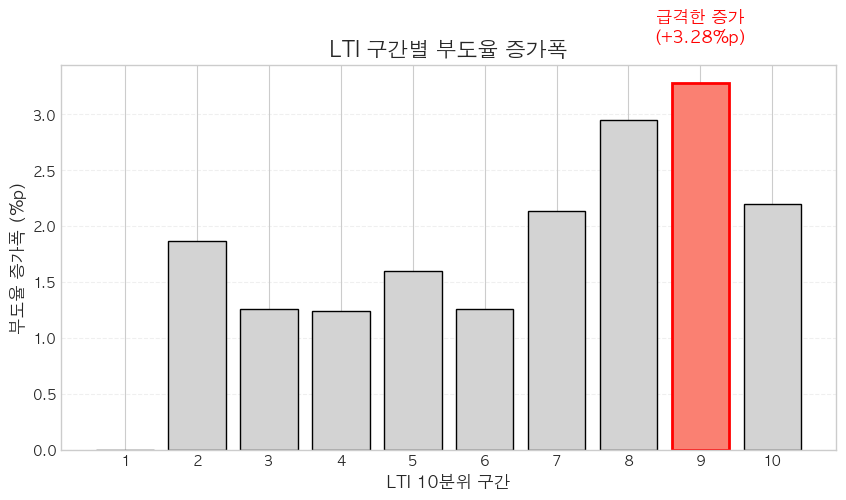

In [260]:
diff_data = [0, 1.87, 1.26, 1.24, 1.60, 1.26, 2.13, 2.95, 3.28, 2.20]
bins = range(1, 11)  # 1구간 ~ 10구간

plt.figure(figsize=(10, 5))

# 기본 회색막대 
bars = plt.bar(bins, diff_data, color='lightgray', edgecolor='black')
# 빨간 막대 
bars[8].set_color('salmon')
bars[8].set_edgecolor('red')
bars[8].set_linewidth(2)

# 바 위에 수치 표시
plt.text(9, 3.52 + 0.1, "급격한 증가\n(+3.28%p)", ha='center', va='bottom', 
         color='red', fontweight='bold', fontsize=12)

plt.title("LTI 구간별 부도율 증가폭", fontsize=15, fontweight='bold')
plt.xlabel('LTI 10분위 구간', fontsize=12)
plt.ylabel('부도율 증가폭 (%p)', fontsize=12)
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.3)
 
plt.show()

In [261]:
# LTI 결론
# 고소득자: LTI가 30% 이상인 경우 대출 한도를 축소하거나 금리를 할증
# 저소득자: LTI가 5~10% 미만으로 아주 낮은 '알짜 고객'은 승인해 주기
# Income과 LTI를 결합한 '승인 매트릭스' 도입
# ---> [대출 승인 거절] 또는 [한도 50% 축소]
# ---> 기대 효과: 고위험군 대출 승인율 감소 예상

In [262]:
# 가설 4 - revol_util

H0_revol = "귀무가설(H0): 리볼빙 사용률(revol_util)은 부도 여부와 상관이 없다"
H1_revol = "대립가설(H1): 리볼빙 사용률(revol_util)은 부도 여부와 상관이 있다."

print(H0_revol)
print(H1_revol)

귀무가설(H0): 리볼빙 사용률(revol_util)은 부도 여부와 상관이 없다
대립가설(H1): 리볼빙 사용률(revol_util)은 부도 여부와 상관이 있다.


In [263]:
# T - 검정

# 연체자(1) & / 완납자(0)
# 이자율

group0 = df_cleaned[df_cleaned['loan_status_binary'] == 0]['revol_util']
group1 = df_cleaned[df_cleaned['loan_status_binary'] == 1]['revol_util']

t_stat, p_val = stats.ttest_ind(group0, group1)

print('----- T-검정 -----')
print(f"T-통계량: {t_stat:.4f}")
print(f"P-value: {p_val:.4g}"'\n')

print("-" * 50)
if p_val < 0.05:
    print(f"결론: P-value가 < 0.05 > 보다 작으므로 귀무가설을 [기각]합니다.")
    print("즉, 리볼빙 사용률이 높을수록 부도율이 지수적으로 상승할 것이다.")
else:
    print(f"결론: P-value가 < 0.05 > 보다 크므로 귀무가설을 [채택]합니다.")
    print("즉, 리볼빙 사용률(revol_util)은 부도 여부와 상관이 없다.")

----- T-검정 -----
T-통계량: -69.6741
P-value: 0

--------------------------------------------------
결론: P-value가 < 0.05 > 보다 작으므로 귀무가설을 [기각]합니다.
즉, 리볼빙 사용률이 높을수록 부도율이 지수적으로 상승할 것이다.


In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def get_optimal_threshold(df, term_val):
    # 1. 해당 기간(term) 데이터 필터링
    subset = df_cleaned[df_cleaned['term'] == term_val]
    group0 = subset[subset['loan_status_binary'] == 0]['revol_util'].dropna()
    group1 = subset[subset['loan_status_binary'] == 1]['revol_util'].dropna()
    
    # 2. KDE 계산
    kde0 = gaussian_kde(group0)
    kde1 = gaussian_kde(group1)
    
    # 3. X축 범위 설정 (이상치 제외, 0~100% 구간 집중)
    x_axis = np.linspace(0, 100, 1000)
    y0 = kde0(x_axis)
    y1 = kde1(x_axis)

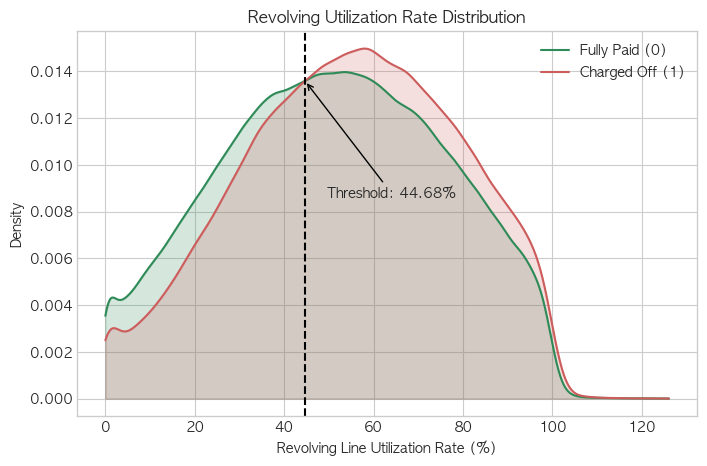

In [265]:
# 구간 제한: 30%~80% 사이에서 교차점 탐색 (120% 방지)
from scipy.stats import gaussian_kde

# 1. KDE 계산 (결측치 제거 필수)
kde0 = gaussian_kde(group0)
kde1 = gaussian_kde(group1)

# 2. X축 범위 설정 (0% ~ 100% 이상인 경우가 있으므로 데이터에 맞춰 설정)
x_axis = np.linspace(group0.min(), group1.max(), 1000)

y0 = kde0(x_axis)
y1 = kde1(x_axis)

search_range = (x_axis > 30) & (x_axis < 80)
idx = np.argmin(np.abs(y0[search_range] - y1[search_range]))
intersect_x = x_axis[search_range][idx]
intersect_y = y0[search_range][idx]

# 시각화 (여백 최적화)
plt.figure(figsize=(8, 5))
plt.plot(x_axis, y0, label='Fully Paid (0)', color='seagreen')
plt.plot(x_axis, y1, label='Charged Off (1)', color='indianred')
plt.fill_between(x_axis, y0, alpha=0.2, color='seagreen')
plt.fill_between(x_axis, y1, alpha=0.2, color='indianred')
plt.axvline(intersect_x, color='black', linestyle='--')

plt.annotate(f'Threshold: {intersect_x:.2f}%', 
             xy=(intersect_x, intersect_y), xytext=(intersect_x+5, intersect_y-0.005),
             arrowprops=dict(arrowstyle='->'))

plt.title('Revolving Utilization Rate Distribution')
plt.xlabel('Revolving Line Utilization Rate (%)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [266]:
# 44.68%를 기준으로 그룹 나누기
under_threshold = df_cleaned[df_cleaned['revol_util'] <= 44.68]['loan_status_binary'].mean()
over_threshold = df_cleaned[df_cleaned['revol_util'] > 44.68]['loan_status_binary'].mean()

print(f"리볼빙 사용률 부도 위험 임계점(revol_util): {intersect_x:.2f}%")

print('----------')
print(f"🟩 리볼빙 44.68% 이하 사용률 고객의 부도율 🟩 {under_threshold*100:.2f}%")
print()
print(f"🟥 리볼빙 44.68% 초과 사용률 고객의 부도율 🟥 {over_threshold*100:.2f}%")
print('----------')
print(f"위험도 차이: {over_threshold / under_threshold:.2f}배")

리볼빙 사용률 부도 위험 임계점(revol_util): 44.68%
----------
🟩 리볼빙 44.68% 이하 사용률 고객의 부도율 🟩 17.36%

🟥 리볼빙 44.68% 초과 사용률 고객의 부도율 🟥 21.66%
----------
위험도 차이: 1.25배


In [267]:
results = []
for term in df_cleaned['term'].unique():
    subset = df_cleaned[df_cleaned['term'] == term]
    
    under = subset[subset['revol_util'] <= 44.68]['loan_status_binary'].mean()
    over = subset[subset['revol_util'] > 44.68]['loan_status_binary'].mean()
    
    results.append({
        'Term': term,
        'Under_44.68': round(under*100,2),
        'Over_44.68': round(over*100,2),
        'Risk_Gap': round(over / under,2)
    })

res_df = pd.DataFrame(results)
print(res_df)

# 36개월: 리스크 1.23배 / 사용률이 높아져도 1.23배
# 60개월: 리스크 1.15배 / 사용률이 높아져도 1.15배
# 즉 60개월 대출기간은 36개월에 비해 리볼빙 사용률이 주는 리스크 신호가 덜 위험

   Term  Under_44.68  Over_44.68  Risk_Gap
0    36        14.09       17.32      1.23
1    60        29.56       33.97      1.15


In [268]:
df_res = df_cleaned.copy()

threshold = 44.68
caution_threshold = threshold * 0.8  # 35.74% > 기존 임계점으로 설정하면 사후관리에 있어서는 너무 늦음 그리하여 80%로 설정

# 3. 리스크 세그먼트 초기화 (기본값 Normal)
df_res['risk_segment'] = 'Normal'

# 4. 조건별 강제 할당 (Vectorized Operation으로 속도와 정확도 향상)
# 주의(Watch) 구간 설정
df_res.loc[df_res['revol_util'] > caution_threshold, 'risk_segment'] = 'Watch (Caution)'

# 고위험(High Risk) 구간 설정 (36개월/60개월 구분)
# term 컬럼에 '36'이 들어있으면 36개월 대출로 판단
is_36 = df_res['term'].astype(str).str.contains('36')

df_res.loc[(df_res['revol_util'] > threshold) & (~is_36), 'risk_segment'] = 'High Risk (Standard)'
df_res.loc[(df_res['revol_util'] > threshold) & (is_36), 'risk_segment'] = 'High Risk (Intensive)'

print("--- 등급별 인원수 확인 ---")
print(df_res['risk_segment'].value_counts())

--- 등급별 인원수 확인 ---
risk_segment
High Risk (Intensive)    600801
Normal                   374312
High Risk (Standard)     212004
Watch (Caution)          156884
Name: count, dtype: int64


In [269]:
# 최종 요약 테이블 생성
summary = df_res.groupby(['term', 'risk_segment']).size().unstack(fill_value=0)

# 보고서용 정렬
cols = ['Normal', 'Watch (Caution)', 'High Risk (Standard)', 'High Risk (Intensive)']
existing_cols = [c for c in cols if c in summary.columns]
summary = summary[existing_cols]

display(summary)

risk_segment,Normal,Watch (Caution),High Risk (Standard),High Risk (Intensive)
term,,,,
36,297588,121376,0,600801
60,76724,35508,212004,0


In [270]:
# 1. 고위험 집중 관리 대상 (36개월 대출 + 임계점 초과)
intensive_action = df_res[df_res['risk_segment'] == 'High Risk (Intensive)']

# 2. 조기 경보 대상 (주의 구간 고객)
caution_list = df_res[df_res['risk_segment'] == 'Watch (Caution)']

print(f"고위험군: {len(intensive_action):,}명\n주의군: {len(caution_list):,}명")

고위험군: 600,801명
주의군: 156,884명


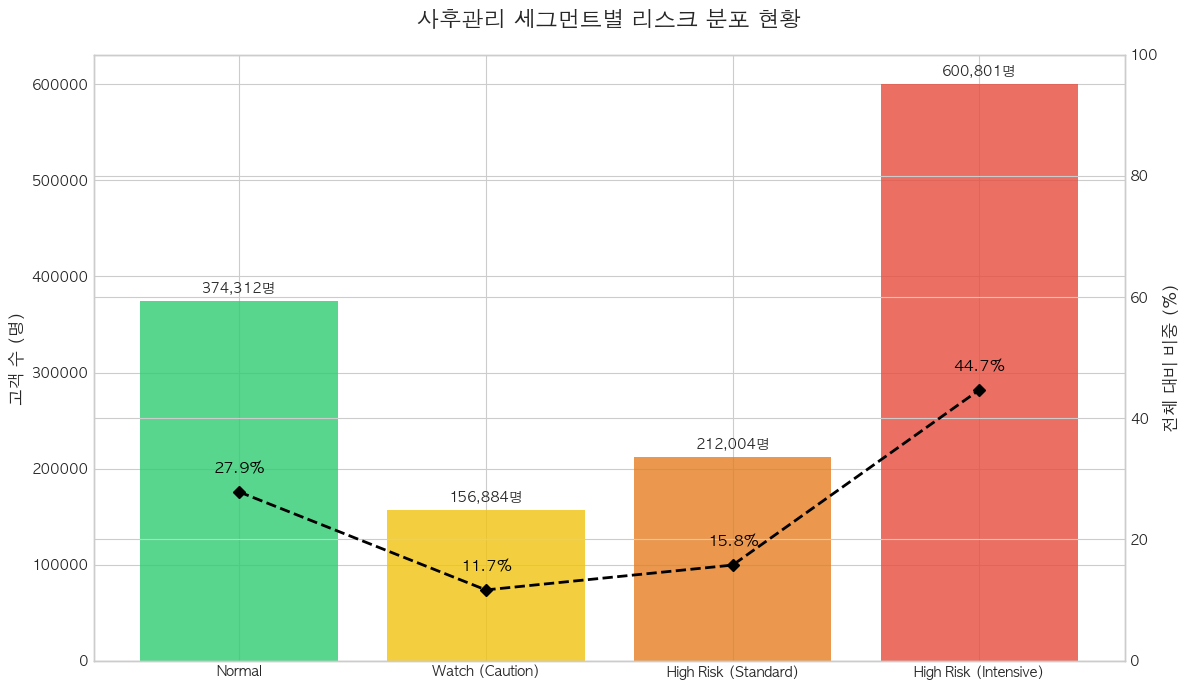

In [271]:
plot_data = df_res['risk_segment'].value_counts().reindex(
    ['Normal', 'Watch (Caution)', 'High Risk (Standard)', 'High Risk (Intensive)']
)

total_count = plot_data.sum()
pct_data = (plot_data / total_count) * 100

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', family='AppleGothic') 
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'] # 초록, 노랑, 주황, 빨강

fig, ax1 = plt.subplots(figsize=(12, 7))

bars = ax1.bar(plot_data.index, plot_data.values, color=colors, alpha=0.8, label='고객 수')
ax1.set_ylabel('고객 수 (명)', fontsize=12)
ax1.set_title('사후관리 세그먼트별 리스크 분포 현황', fontsize=16, pad=20)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5000,
             f'{int(height):,}명', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(plot_data.index, pct_data.values, color='black', marker='D', linestyle='--', linewidth=2, label='비중 (%)')
ax2.set_ylabel('전체 대비 비중 (%)', fontsize=12)
ax2.set_ylim(0, 100)

for i, v in enumerate(pct_data.values):
    ax2.text(i, v + 3, f'{v:.1f}%', ha='center', color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()